In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np

from trainer import fit

/home/zkpk/anaconda3/envs/ESC50/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.utils.data.sampler import BatchSampler
class BalancedBatchSampler1(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = np.array(labels, dtype=np.float32)
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(self.labels == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [3]:
torch.cuda.set_device(7)
pkl_dir = "/home/zkpk/dataset/Data/pth/"

In [4]:
import datasetaug
import pickle

In [5]:
import datasetaug
train_dataset = datasetaug.fetch_dataloader(pkl_dir + "pthtraining128mel1.pkl", dataset_name= "GTZAN", batch_size = 64, num_workers= 4, mode= "train")
test_dataset = datasetaug.fetch_dataloader(pkl_dir + "pthvalidation128mel1.pkl", dataset_name= "GTZAN", batch_size = 64, num_workers= 4, mode= "test")

In [6]:
train_batch_sampler = BalancedBatchSampler1(train_dataset.targets, n_classes=10, n_samples=5)
test_batch_sampler = BalancedBatchSampler1(test_dataset.targets, n_classes=10, n_samples=5)

In [7]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [8]:
class OnlineBinaryTripletLoss(nn.Module):
    """
    Online Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, lam, triplet_selector):
        super(OnlineBinaryTripletLoss, self).__init__()
        self.lam = lam
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()
        a = embeddings[triplets[:, 0]].unsqueeze(-1)
        p = embeddings[triplets[:, 1]].unsqueeze(-2)
        n = embeddings[triplets[:, 2]].unsqueeze(-2)

        theta_ap = torch.bmm(p, a)/2
        theta_an = torch.bmm(n, a)/2

        b = torch.sign(embeddings)
        reg = (b-embeddings).pow(2).sum(1).sum()

        p = theta_ap - theta_an - self.margin 
        losses = -(p - torch.log(1 + torch.exp(p))).sum() +(self.lam*reg).sum()
        return losses, len(triplets)

In [9]:
from itertools import combinations

def pdist(vectors):
  theta_dist = torch.mm(vectors, vectors.T)/2
  return theta_dist


class TripletSelector:
    """
    Implementation should return indices of anchors, positive and negative samples
    return np array of shape [N_triplets x 3]
    """

    def __init__(self):
        pass

    def get_triplets(self, embeddings, labels):
        raise NotImplementedError

class AllTripletSelector(TripletSelector):
    """
    Returns all possible triplets
    May be impractical in most cases
    """

    def __init__(self):
        super(AllTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # Add all negatives for all positive pairs
            temp_triplets = [[anchor_positive[0], anchor_positive[1], neg_ind] for anchor_positive in anchor_positives
                             for neg_ind in negative_indices]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))


def hardest_negative(loss_values):
    hard_negative = np.argmax(loss_values)
    return hard_negative if loss_values[hard_negative] > 0 else None


def random_hard_negative(loss_values):
    hard_negatives = np.where(loss_values > 0)[0]
    return np.random.choice(hard_negatives) if len(hard_negatives) > 0 else None


def semihard_negative(loss_values, margin):
    semihard_negatives = np.where(np.logical_and(loss_values < margin, loss_values > 0))[0]
    return np.random.choice(semihard_negatives) if len(semihard_negatives) > 0 else None

class FunctionNegativeTripletSelector(TripletSelector):
    """
    For each positive pair, takes the hardest negative sample (with the greatest triplet loss value) to create a triplet
    Margin should match the margin used in triplet loss.
    negative_selection_fn should take array of loss_values for a given anchor-positive pair and all negative samples
    and return a negative index for that pair
    """

    def __init__(self, margin, negative_selection_fn, cpu=True):
        super(FunctionNegativeTripletSelector, self).__init__()
        self.cpu = cpu
        self.margin = margin
        self.negative_selection_fn = negative_selection_fn

    def get_triplets(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] - self.margin
                loss_values = -(loss_values)
                loss_values = loss_values.data.cpu().numpy()
                hard_negative = self.negative_selection_fn(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)

        return torch.LongTensor(triplets)


def HardestNegativeTripletSelector1(margin, cpu=False): return FunctionNegativeTripletSelector(margin=margin,
                                                                                 negative_selection_fn=hardest_negative,
                                                                                 cpu=cpu)


def RandomNegativeTripletSelector1(margin, cpu=False): return FunctionNegativeTripletSelector(margin=margin,
                                                                                negative_selection_fn=random_hard_negative,
                                                                                cpu=cpu)


def SemihardNegativeTripletSelector1(margin, cpu=False): return FunctionNegativeTripletSelector(margin=margin,
                                                                                  negative_selection_fn=lambda x: semihard_negative(x, margin),
                                                                                  cpu=cpu)

In [10]:
# Set up the network and training parameters

import torch.optim
from networks import EmbeddingNet
from losses import OnlineTripletLoss
import torchvision.models
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric
import densenet

margin = 16
model = densenet.DenseNet("gtzan", pretrained= True)


/home/zkpk/anaconda3/envs/ESC50/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/zkpk/anaconda3/envs/ESC50/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
model

DenseNet(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1,

In [11]:
model.cuda()
loss_fn = OnlineBinaryTripletLoss(margin, 0, RandomNegativeTripletSelector1(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 7, gamma=0.8, last_epoch=-1)
n_epochs = 15
log_interval = 15
loss_fn = OnlineBinaryTripletLoss(margin, 10, RandomNegativeTripletSelector1(margin))

In [12]:
online_train_loader= torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler)

In [13]:
from trainer import fit
cuda = torch.cuda.is_available()

In [14]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

/home/zkpk/anaconda3/envs/ESC50/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


KeyboardInterrupt: 

In [16]:
torch.save(model, './triplet_resnet50_epoche_1.mdl')

In [11]:
model = torch.load('./triplet_densenet_epoche8_50_60.mdl')

In [9]:
model

DenseNet(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1,

In [12]:
# Freeze all the parameters in the model
def freeze_model(model):
  for params in model.parameters():
    params.requires_grad=False

def unfreeze_model(model):
  for params in model.parameters():
    params.requires_grad= True

# check if all the parameters have been freezed
def list_trainable(model):
  for params in model.parameters():
    print(params.requires_grad)
  
# delete the last layers
def del_last_layers(model_class, num_layers):
  model_class = nn.Sequential(*list(model_class.children())[:-num_layers])
  return model_class

In [13]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size= 32, shuffle= True, num_workers=8)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = True, num_workers = 8)

In [14]:
device = torch.device("cuda:7" if torch.cuda.is_available() else 'cpu')
def create_embeddings(model, embedding_size):
  
 
  model.eval()
  features = {}
  targets = {}
  model.to(device)
  features['train'] = np.empty([0, embedding_size])
  targets['train'] = np.empty([0, ])

  features['test'] = np.empty([0, embedding_size])
  targets['test'] = np.empty([0,])

  for i, (images,target) in enumerate(train_dataloader):
   
    images = images.to(device)
    target = target.to(device)

    try:
      print("1"*10)
      output = model(images).cpu().detach().numpy()
      print("2"*10)
      features['train'] = np.append(features['train'],output, axis=0)
      print("3"* 10)
      targets['train'] = np.append(targets['train'],target.cpu(), axis=0)
    except:
      print('error occured: ')
      return (None, None)
    
    if i%100 == 0:
      print(i)

  for i, (images,target) in enumerate(test_dataloader):
    images = images.to(device)
    target = target.to(device)

    output = model(images).cpu().detach().numpy()
    features['test'] = np.append(features['test'],output, axis=0)
    targets['test'] = np.append(targets['test'],target.cpu(), axis=0)

    if i%100 == 0:
      print(i)
  return (features, targets)

In [15]:
model.cuda()

DenseNet(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1,

In [16]:
features, targets = create_embeddings(model, 128)


1111111111
2222222222
3333333333
0
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
1111111111
2222222222
3333333333
0


In [17]:
model.classifier = Identity()

In [22]:
model

DenseNet(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1,

In [35]:
model_emb = model
freeze_model(model_emb)
print(model_emb)

DenseNet(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1,

In [18]:
# Save and load
import pickle

def save(features, targets, model_name):
  with open(model_name+'.embs', 'wb') as file:
    pickle.dump((features,targets), file)
    print('file saved in ', model_name)

def load(model_name):
  with open(model_name+'.embs', 'rb') as file:
    features, targets = pickle.load(file)
    return (features, targets)

In [34]:
class Solution(object):
    def hammingDistance(self, x, y):
        """
        :type x: int
        :type y: int
        :rtype: int
        """
        hamming_distance = 0
        s = str(bin(x^y))
        for i in range(2,len(s)):
            if int(s[i]) is 1:
                hamming_distance += 1
        return hamming_distance 


<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_711323/633707474.py:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if int(s[i]) is 1:


In [36]:

from scipy.spatial import distance

In [47]:
features_sign = {}
features_sign['train'] = np.sign(features['train'])
features_sign['test'] = np.sign(features['test'])
print(features_sign['test'][2][:16])
for i in range (50):
    if(targets['test'][i]==2):
        print(i)

[ 1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1. -1. -1. -1. -1.  1.]
1
9
21
36
39


In [51]:
print(targets['test'][0])

9.0


In [56]:
for i in range (50):
    print("="*10)
    #distance.euclidean(vector_1, vector_2)
    print(distance.euclidean(features['test'][0], features['test'][i+1]))
    
    print(targets['test'][i+1])

23.856969821484935
2.0
27.707498125231506
0.0
16.825434224295403
8.0
15.165925619884378
7.0
11.995351138987184
9.0
19.210726738305688
1.0
5.710708467804516
9.0
18.481269674980638
4.0
25.311473029461304
2.0
19.809467773109898
5.0
30.73087492129961
0.0
15.969752053002027
8.0
39.45943021735156
3.0
19.73729329562782
7.0
19.772267763988467
5.0
4.953966116437062
9.0
18.846749927705346
7.0
17.962735722911557
6.0
19.681002629939158
3.0
20.1214328821036
6.0
19.021101226171997
2.0
20.95946106411366
7.0
14.3487140232136
7.0
17.307999349484014
9.0
14.607421015423398
8.0
25.91781527575755
0.0
25.367675821195522
3.0
9.795848263402643
9.0
20.5014649583922
4.0
32.891702756936134
3.0
20.3687130455078
1.0
14.267059199096698
4.0
20.351022257670312
4.0
17.184808328610373
6.0
20.13270655900179
5.0
20.08548494428223
2.0
13.869026519393502
4.0
25.60348987578794
0.0
19.58142972686615
2.0
15.358240090987893
0.0
18.09907540760352
0.0
17.91831292050202
7.0
16.343269616492986
8.0
19.489627098295813
8.0
6.49429916

In [ ]:
distance.hamming(features_sign['test'][1], features_sign['test'][19])

In [29]:
print(features['test'][2][:16])

[ 3.21178102  2.85939145 -3.01973414  2.33299947  2.7595818   0.01808556
 -2.19752073  4.75103331  1.8573221   4.68954897 -0.92372572 -0.5080421
 -0.02671963 -1.14242637 -2.48704481  0.85999322]


In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

k_range = range(25,30)

def search_knn_accuracies(k_range, features, targets):
  acc = []
  for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(features['train'], targets['train'])
    #print('finished fitting')
    predict = knn.predict(features['test'][:128,:])
    #print('predicted')
    score = metrics.accuracy_score(targets['test'][:128], predict)
    print('K value: %d, accuracy: %0.7f' %(k, score))
    acc.append(score)
  print('Mean accuracy ',sum(acc)/len(acc))

# the best score was obtained when k = 20:24
search_knn_accuracies(k_range, features, targets)

K value: 25, accuracy: 0.7437186
K value: 26, accuracy: 0.7437186
K value: 27, accuracy: 0.7437186
K value: 28, accuracy: 0.7437186
K value: 29, accuracy: 0.7437186
Mean accuracy  0.7437185929648241


In [ ]:
device = torch.device("cuda:7" if torch.cuda.is_available() else 'cpu')
def create_embeddings(model, embedding_size):
  
 
  model.eval()
  features = {}
  targets = {}
  model.to(device)
  features['train'] = np.empty([0, embedding_size])
  targets['train'] = np.empty([0, ])

  features['test'] = np.empty([0, embedding_size])
  targets['test'] = np.empty([0,])

  for i, (images,target) in enumerate(train_dataloader):
   
    images = images.to(device)
    target = target.to(device)

    try:
      print("1"*10)
      output = model(images).cpu().detach().numpy()
      print("2"*10)
      features['train'] = np.append(features['train'],output, axis=0)
      print("3"* 10)
      targets['train'] = np.append(targets['train'],target.cpu(), axis=0)
    except:
      print('error occured: ')
      return (None, None)
    
    if i%100 == 0:
      print(i)

  for i, (images,target) in enumerate(test_dataloader):
    images = images.to(device)
    target = target.to(device)

    output = model(images).cpu().detach().numpy()
    features['test'] = np.append(features['test'],output, axis=0)
    targets['test'] = np.append(targets['test'],target.cpu(), axis=0)

    if i%100 == 0:
      print(i)
  return (features, targets)

In [26]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from sklearn.manifold import TSNE
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123
# need to create a subset of the data, too much time to process otherwise
# features['train': 800 * 128, 'test':200 * 128 ]  
x_subset = features['train'][:5000]
y_subset = targets['train'][:5000]


labels = {
     0: 'blues',  
     1: 'classical',
     2: 'country',
     3: 'disco',
     4: 'hippop',
     5: 'jazz',
     6: 'metal',
     7: 'pop',
     8: 'reggae',
     9: 'rock',
}

#visulize
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

   
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(labels[i]), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [27]:
# do pca before passing to tsne to reduce noice and fast performance
time_start = time.time()

pca_50 = PCA(n_components=32)

pca_result_50 = pca_50.fit_transform(x_subset)

print('PCA with 50 components done! Time elapsed: {} seconds'.format(time.time()-time_start))

print('Cumulative variance explained by 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))
# perform tsne on 50 components
time_start = time.time()


fashion_pca_tsne = TSNE(random_state=RS).fit_transform(pca_result_50)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

PCA with 50 components done! Time elapsed: 0.20289325714111328 seconds
Cumulative variance explained by 50 principal components: 0.9999057924229173


/home/zkpk/anaconda3/envs/ESC50/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/zkpk/anaconda3/envs/ESC50/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 274.8763029575348 seconds


In [22]:
print(x_subset.shape)
print(pca_result_50.shape)
print(fashion_pca_tsne.shape)
print(pca_result_50)
print(fashion_pca_tsne)




(800, 128)
[-25.128136 -13.695255]


/tmp/ipykernel_701787/1403172944.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])


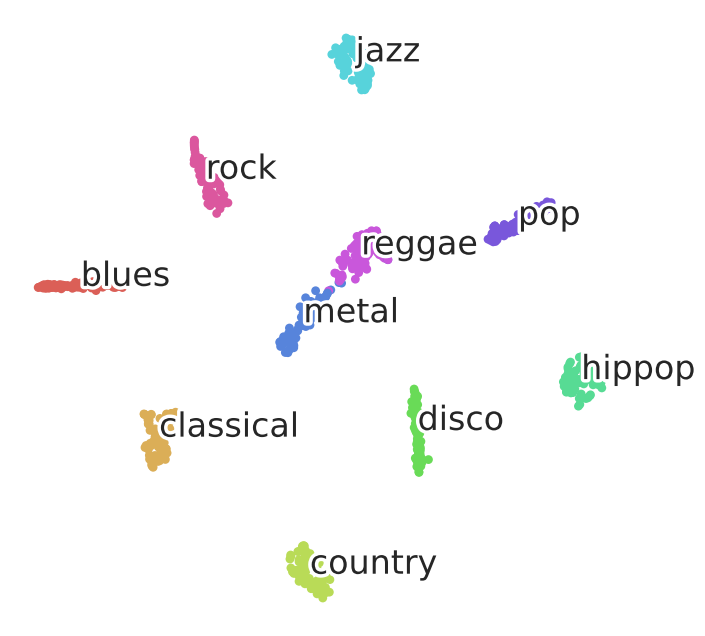

In [28]:
fashion_scatter(fashion_pca_tsne, y_subset)
plt.show()

In [29]:
def average_precision(vector):
  assert vector.ndim == 1
  sum_precision = 0
  num_true_values = 0
  for i, value in enumerate(vector):
    if value:
      num_true_values += 1
    sum_precision += value*num_true_values/(i+1)
  return sum_precision/(sum(vector)+ 0.00000001)
def mAP(features, targets):

  num_elements_to_retrieve = 50
  num_test_queries = 36

  knn = KNeighborsClassifier(n_neighbors=29)
  knn.fit(features['train'], targets['train'])
  indexes = knn.kneighbors(features['test'][:num_test_queries],num_elements_to_retrieve, return_distance=False)
  results = targets['train'][indexes] == targets['test'][:num_test_queries].reshape(-1, 1)
  APs = []
  for vector in results:
    APs.append(average_precision(vector))
  print('mAP is: ',sum(APs)/len(APs))
mAP(features, targets)

mAP is:  0.8107141535311571
